In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from colorama import Fore

In [30]:
# predictions = pd.read_csv('training_data_non_model.csv')
predictions = pd.read_csv('testing_data_non_model.csv')
increase_factor = 1.5

In [31]:
predictions.index = pd.to_datetime(predictions['Date'])

In [32]:
dataset = predictions.copy()

In [33]:
dataset["new_rfr"] = dataset["daily_risk_free_rate"] * increase_factor

In [34]:
# use the EWMA to do the trading strategy
def ewma(data, window):
    return data.ewm(span=window).mean()

fast_window = 50
slow_window = 90

dataset['fast'] = ewma(dataset['Close'], fast_window)
dataset['slow'] = ewma(dataset['Close'], slow_window)

In [35]:
def get_signals(data: pd.DataFrame) -> pd.DataFrame:
    dataset = data.copy()
    dataset['signal'] = 0
    for i in range(1, len(dataset)):
        
        # short signal
        if dataset['fast'].iloc[i] < dataset['slow'].iloc[i] and dataset['fast'].iloc[i-1] > dataset['slow'].iloc[i-1]:
            dataset.loc[dataset.index[i], 'signal'] = -1
        
        # buy signal
        elif dataset['fast'].iloc[i] > dataset['slow'].iloc[i] and dataset['fast'].iloc[i-1] < dataset['slow'].iloc[i-1]:
            dataset.loc[dataset.index[i], 'signal'] = 1
    return dataset

dataset = get_signals(dataset)

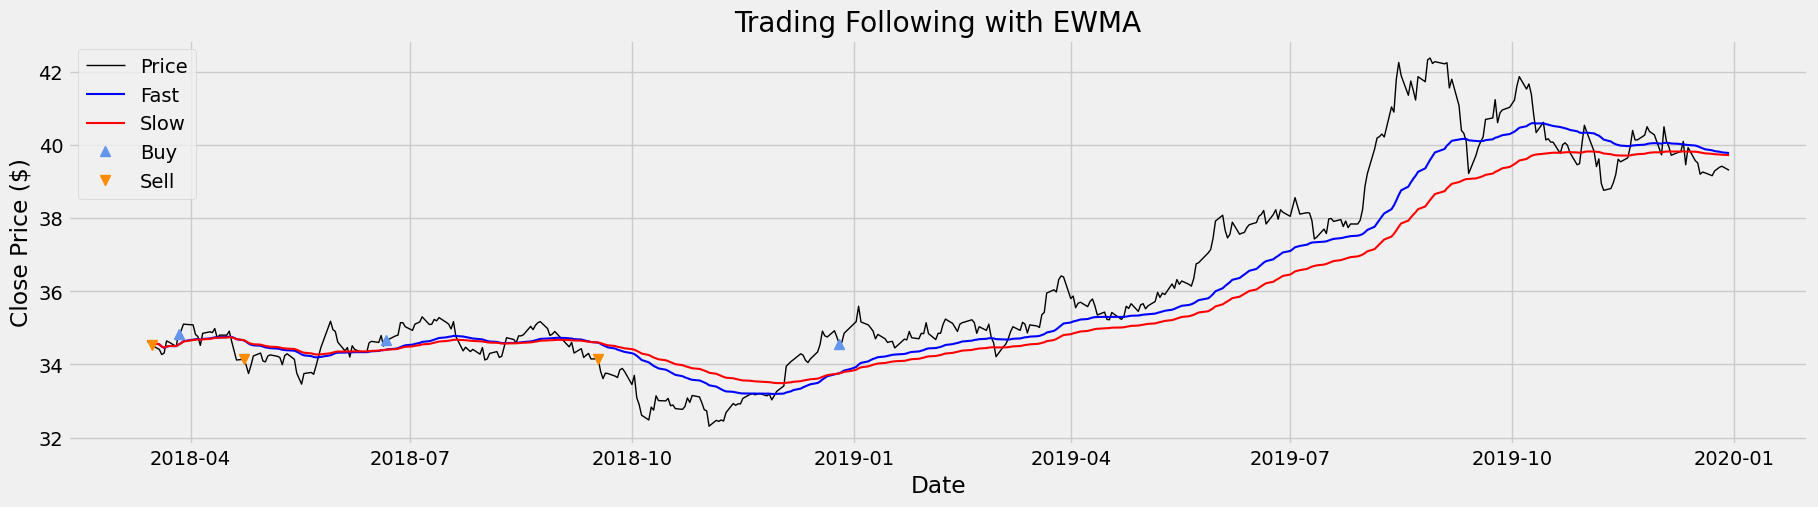

In [36]:
plt.figure(figsize=(20, 5))
plt.style.use('fivethirtyeight') 

plt.title('Trading Following with EWMA')

# Plot main price line
plt.plot(dataset.index, dataset['Close'], label='Price', color='black', linewidth=1)  # Thicker price lin

# Differentiate buy and sell signals with markers and colors
buy_signals = dataset[dataset['signal'] == 1].index
sell_signals = dataset[dataset['signal'] == -1].index

# Plot fast and slow EWMAs
plt.plot(dataset.index, dataset['fast'], label='Fast', color='blue', linewidth=1.5)  # Thinner EWMA lines
plt.plot(dataset.index, dataset['slow'], label='Slow', color='red', linewidth=1.5)

plt.plot(buy_signals, dataset['Close'][buy_signals], marker='^', linestyle='', color='cornflowerblue', label='Buy', markersize=7) 
plt.plot(sell_signals, dataset['Close'][sell_signals], marker='v', linestyle='', color='darkorange', label='Sell', markersize=7)

plt.xlabel(xlabel='Date')
plt.ylabel(ylabel='Close Price ($)')

plt.legend()
plt.show()

In [37]:

inital_cash = 200000
leverage_factor = 10
margin = [inital_cash]
position = [0]
cash = [inital_cash*leverage_factor]
previous_signal = 0
re = [0]

bank_account = [0]
high_bank_account = [0]

for i in range(0, len(dataset)-1):
    current_signal = dataset['signal'].iloc[i]
    current_price = dataset['Close'].iloc[i]
    current_rfr = dataset['daily_risk_free_rate'].iloc[i]
    current_high_rfr = dataset['new_rfr'].iloc[i]
    
    current_position = position[-1]
    current_cash = cash[-1]
    current_bank_account = bank_account[-1]
    current_high_bank_account = high_bank_account[-1]
    current_margin = margin[-1]
    current_re = re[-1]
    
    # if you were longing, and the price goes up and over the margin, then you can take the excess return
    if current_position * current_price > current_margin * leverage_factor:
        excess_return = current_position * current_price - current_margin * leverage_factor
        excess_stock = excess_return / current_price
        current_position -= excess_stock
        current_bank_account += excess_return
    
    # if you were shorting, and the price goes up and over the margin, then you can take the excess loss
    if (-current_position * current_price) > current_margin * leverage_factor:
        excess_return = (-current_position * current_price) - current_margin * leverage_factor
        excess_stock = excess_return / current_price
        current_position += excess_stock
    
    if current_signal == 0:
        if previous_signal == 1:
            if current_price < long_price:
                unit_loss = abs(long_price - current_price)
                loss = abs(current_position) * unit_loss
                if current_margin - loss <= 0:
                    print("Bank is calling back the loan")
                    break
                
        if previous_signal == -1:
            if current_price > short_price:
                unit_loss = abs(current_price - short_price)
                loss = abs(current_position) * unit_loss
                if current_margin - loss <= 0:
                    print("Bank is calling back the loan")
                    break
                
        if current_position > 0:
            current_re = (current_price - long_price) / long_price
            
        if current_position < 0:
            current_re = (short_price - current_price) / short_price
    
    if current_signal == 1:
        # if we are already in a short position, then we close the short position
        if previous_signal == -1:
            stock_for_short = abs(current_position)
            current_position = 0
            unit_profits = short_price - current_price
            profits = stock_for_short * unit_profits
            
            current_margin += profits
            current_re = unit_profits / short_price
            
            if current_margin <= 0:
                print("Bank is calling back the loan")
                break
            previous_signal = 0
            
        # if we closed the short position, or we are in a initial position, then we buy
        if previous_signal == 0:
            
            current_cash = current_margin * leverage_factor
            
            stock_to_buy = current_cash / current_price
            current_position += stock_to_buy
            long_price = current_price
            
            previous_signal = 1

    if current_signal == -1:
        if previous_signal == 1:
            stock_for_long = current_position
            current_position = 0
            unit_profits = current_price - long_price
            profits = stock_for_long * unit_profits
            
            current_margin += profits
            current_re = unit_profits / long_price
            
            if current_margin <= 0:
                print("Bank is calling back the loan")
                break
            
            previous_signal = 0
        
        if previous_signal == 0:
            
            current_cash = current_margin * leverage_factor
            
            stock_to_borrow = current_cash / current_price
            current_position -= stock_to_borrow
            short_price = current_price
            
            previous_signal = -1
    
    current_high_bank_account = current_bank_account
    current_interest = current_bank_account * current_rfr
    current_high_interest = current_high_bank_account * current_high_rfr
    current_bank_account += current_interest
    current_high_bank_account += current_high_interest
    
    re.append(current_re)
    margin.append(current_margin)
    position.append(current_position)
    cash.append(current_cash)
    bank_account.append(current_bank_account)
    high_bank_account.append(current_high_bank_account)

current_price = dataset['Close'].iloc[-1]
current_bank_account = bank_account[-1]

current_interest = current_bank_account * current_rfr
current_high_interest = current_high_bank_account * current_high_rfr
current_bank_account += current_interest
current_high_bank_account += current_high_interest

if current_position > 0:
    profits = current_position * (current_price - long_price)
    current_margin += profits
    current_position = 0
    current_re = (current_price - long_price) / long_price
if current_position < 0:
    profits = -current_position * (short_price - current_price)
    current_margin += profits
    current_position = 0
    current_re = (short_price - current_price) / short_price

bank_account.append(current_bank_account)
high_bank_account.append(current_high_bank_account)
re.append(current_re)
margin.append(current_margin)
position.append(current_position)
cash.append(current_cash)

In [38]:
report_df = pd.DataFrame({
    'margin': margin[1:],
    'position': position[1:],
    'cash': cash[1:],
    "bank_account": bank_account[1:],
    "bank_account_with_high_rfr": high_bank_account[1:],
    'excess_return': re[1:],
})
report_df.index = dataset.index

In [39]:
target_data = dataset.copy()
target_data = target_data.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close', 'fast', 'slow', "excess return", "return"])
final_result = pd.concat([target_data, report_df], axis=1)

In [40]:
final_result.columns

Index(['Date', 'Close', 'daily_risk_free_rate', 'new_rfr', 'signal', 'margin',
       'position', 'cash', 'bank_account', 'bank_account_with_high_rfr',
       'excess_return'],
      dtype='object')

In [41]:
final_result["theta"] = final_result["position"] * final_result["Close"]
final_result["pnl"] = (final_result["excess_return"] - final_result["daily_risk_free_rate"]) * final_result["theta"]

final_result["pnl_capital"] = final_result["bank_account"] - final_result["bank_account"].shift(1)

final_result["pnl_total"] = final_result["pnl"] + final_result["pnl_capital"]
final_result["cumulative_pnl"] = final_result["pnl"].cumsum()

final_result["cumulative_pnl_capital"] = final_result["pnl_capital"].cumsum()

final_result["cumulative_pnl_total"] = final_result["pnl_total"].cumsum()
final_result["turn_over_theta"] = abs(final_result["theta"] - final_result["theta"].shift(1))
final_result["turn_over_theta"] = final_result["turn_over_theta"].fillna(0)
final_result["cumulative_turn_over_theta"] = final_result["turn_over_theta"].cumsum()
final_result["turn_over_units"] = abs(final_result["position"] - final_result["position"].shift(1))
final_result["turn_over_units"] = final_result["turn_over_units"].fillna(0)
final_result["Upper_bound"] = final_result["margin"] * leverage_factor
final_result["Lower_bound"] = -final_result["margin"] * leverage_factor

final_result["pnl_150"] = (final_result["excess_return"] - final_result["new_rfr"]) * final_result["theta"]
final_result["pnl_capital_150"] = final_result["bank_account_with_high_rfr"] - final_result["bank_account_with_high_rfr"].shift(1)
final_result["pnl_total_150"] = final_result["pnl_150"] + final_result["pnl_capital_150"]
final_result["cumulative_pnl_150"] = final_result["pnl_150"].cumsum()
final_result["cumulative_pnl_capital_150"] = final_result["pnl_capital_150"].cumsum()
final_result["cumulative_pnl_total_150"] = final_result["pnl_total_150"].cumsum()

In [42]:
# final_result.to_csv("./training/EWMA_training.csv")
# final_result.to_csv("./testing/EWMA_testing.csv")

In [43]:
final_result["bank_account"][-1] + final_result["margin"][-1]

/var/folders/20/0y46cgg97gs8kf_s9bthlzgm0000gn/T/ipykernel_69076/1483742896.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_result["bank_account"][-1] + final_result["margin"][-1]


425214.3134601363